## Reweighting of two 2D Gaussians with Boosted Decision Trees

The following demonstates a multivariate reweighting procedure. The task is to reweight a 2D Gaussian with no correlation between feature1 and feature2 such that it fits another 2D Gaussian with correlated features.
Both data sets have the some one dimensional projections and can therefore not be adapted by 1 dimensional reweighting. Instead, a multivariate reweighting method is employed.

This notebook requires the ml_hep library:
pip install hep_ml

For documentation of the reweighter and other interesting stuff: https://arogozhnikov.github.io/hep_ml/

An explanation of the reweighting algorithm: http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html

For my slides and summary on dataset shifts check out: https://indico.cern.ch/event/627870/ ("Monte Carlo adaption to real data using BDTs")

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import numpy as np
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore') #suppress deprecation warnings

## Create data
We create two 2D datasets that are sampled from Gaussians. One with a correlation between the features the other without.


In [12]:
n=500 #number of data points to be plotted for scatter plots

mean1, cov1, n_samples1 = np.array([0.,0.]), np.array([[3,0.0],[0.0,2]]), 200000
data1=np.random.multivariate_normal(mean1,cov1,size=n_samples1)

mean2, cov2, n_samples2 = np.array([0.,0.]), np.array([[3,1.8],[1.8,2]]), 200000
data2=np.random.multivariate_normal(mean2,cov2,size=n_samples2)

Function for scatter plots that show weights as marker size

In [13]:
def make_plot(data1,data2,w1,w2):

    fig, axScatter = plt.subplots(figsize=(15, 15))
    
    x1=data1[:,0]
    y1=data1[:,1]
    
    x2=data2[:,0]
    y2=data2[:,1]
    
    #Plot data
    plt.rc('font',size=25)
    axScatter.scatter(x1,y1,color='b',s=100*w1-30,alpha=0.7)
    axScatter.scatter(x2,y2,color='g',s=100*w2-30,alpha=0.3)
    axScatter.set_aspect(1.)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.ylim(-8,8);
    plt.xlim(-8,8);

    #Create new axes for projections
    divider = make_axes_locatable(axScatter)
    axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
    axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

    # make some labels invisible
    plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),visible=False)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x1)), np.max(np.fabs(y1))])
    lim = (int(xymax/binwidth) + 1)*binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x1,color='b', bins=bins, alpha=0.5)
    axHisty.hist(y1,color='b', bins=bins,alpha=0.5, orientation='horizontal')
    axHistx.hist(x2,color='g', bins=bins,alpha=0.5)
    axHisty.hist(y2,color='g', bins=bins,alpha=0.5, orientation='horizontal')

    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.

    histTicks = np.arange(0,0,100)
    #axHistx.axis["bottom"].major_ticklabels.set_visible(False)
    for tl in axHistx.get_xticklabels():
        tl.set_visible(False)
    axHistx.set_yticks(histTicks)

    #axHisty.axis["left"].major_ticklabels.set_visible(False)
    for tl in axHisty.get_yticklabels():
        tl.set_visible(False)
    axHisty.set_xticks(histTicks)

    #axScatter.legend(loc='upper left')
    #plt.title('Multivariate Guassians',y=1.2,x=-2.5,fontsize=20)
    plt.draw()
    plt.show() 

Plot datasets with all weights set to 1.

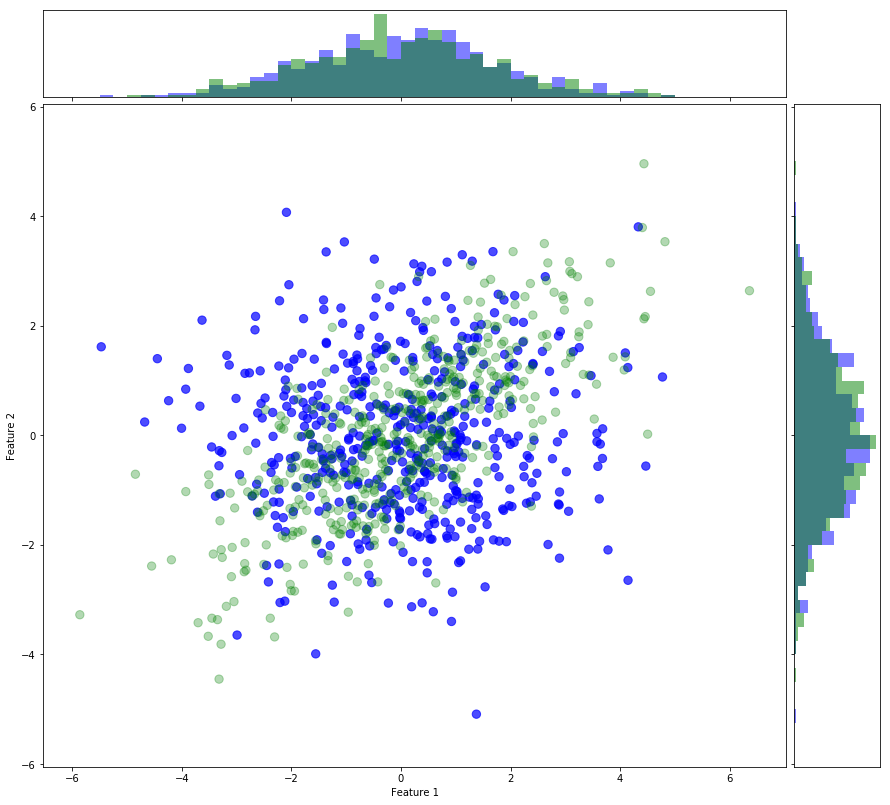

In [14]:
w1=np.ones(len(data1))
w2=np.ones(len(data2))

make_plot(data1[:n],data2[:n],w1[:n],w2[:n])

Train a reweighter using its fit function: first argument is the dataset that shall be adapted to the dataset in the second argument.

The arguments of GBReweighter() are the hyperparameters of the reweighter and may be used to achieve the desired working point in terms of reweighting precision and statistical robustness.

In [15]:
from hep_ml.reweight import GBReweighter
reweighter = GBReweighter(n_estimators=3, max_depth=8, learning_rate=0.9, min_samples_leaf = 100)

_=reweighter.fit(data1[:], data2)

Let the reweighter predict the weights for the dataset that shall be reweighted.

In the scatter plot the weigths are represented by the marker size. The blue weights were modified by the reweighter according to the modeled ratio of the 2 datasets. The weights of the green dataset remain 1.

Note: in a real application this procedure would be bad practice! As in normal classification, one should evaluate the algorithm only on data that was not seen during training.

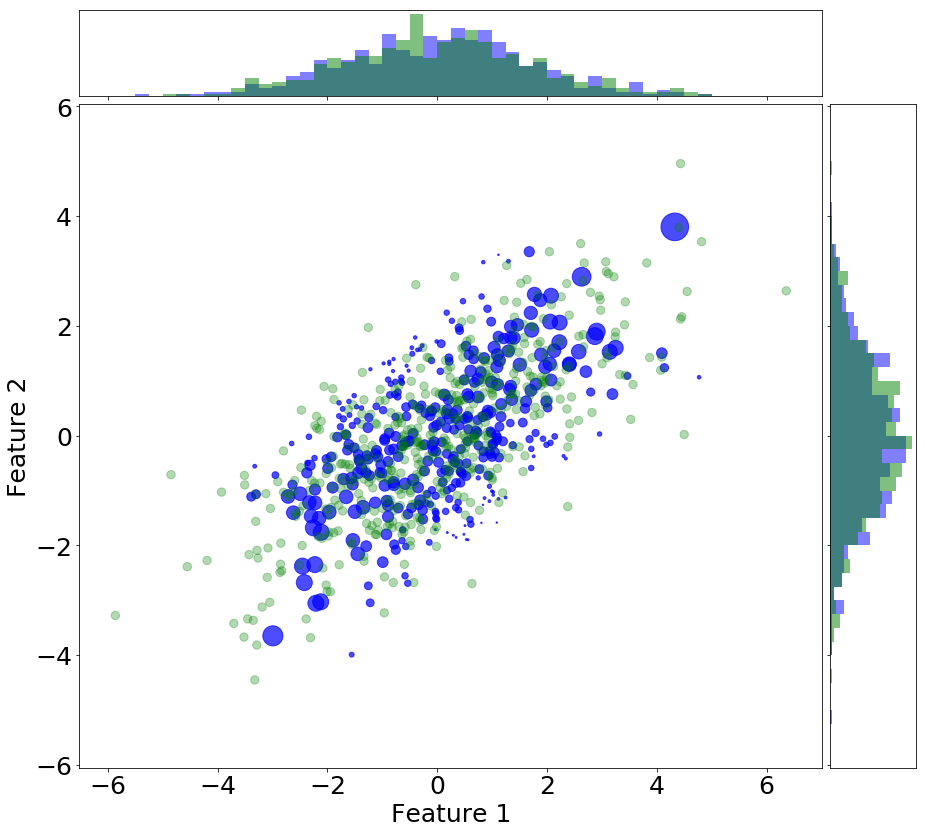

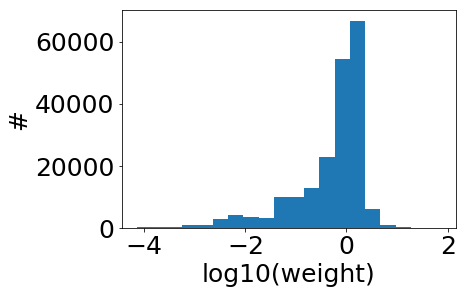

In [16]:
w1 = reweighter.predict_weights(data1)

make_plot(data1[:n],data2[:n],w1[:n],w2[:n])
plt.hist(np.log10(w1),bins=20)
plt.xlabel('log10(weight)')
plt.ylabel('#')
_=plt.show

The reweighting algorithm adjusts the weights as expected: larger weights where blue is underrepresented and vice versa.

An example for domain shift will be added here!